# Project X Report

## Team members: 

## Introduction
The idea behind our analysis is to use machine learning techniques and algorithms to determine which physiochemical properties make a wine 'good'! The dataset is related to red variants of the Portuguese "Vinho Verde" wine. We have used decision trees and neural networks to train the model on the data and predict the quality of wine. Both the models performed similar in the experiments.

## Dataset
The dataset contains 1599 instances of physiochemical properties of wine. All the wine samples are related to red variants of Portuguese "Vinho Verde" wine. This dataset was pretty clean with no null values. Following are the independent variables we have in our dataset:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol

The dependent variable is 'quality' which is the score between 1 and 10 where 1 represents poor quality and 10 represents the highest quality of wine. The dataset was unbalanced between the different categories of 'quality', to make it a balanced dataset and to also deliver more value from our analysis, we have divided the data amongst two categories; 'good' and 'bad' and trained our models on the transformed data.


## Analysis technique

#### Exploratory Data Analysis
To start with the analysis we first studied the data and checked if it is suitable for modelling and further analysis. We started with plotting out the frequencies of our dependent categories just to get an idea about the distribution of our dependent variable. Once we figured out that it is quite unbalanced, we modified the target variable and divided the data into two classes based on the value of 'quality' of each wine. We have used a criteria of naming a wine 'bad' if its quality is <=5 and 'good' if its quality >=6. The other reason for dividing the data is because it seemed to be delivering more value to the user where we just tell him whether the quality of wine is 'good' or 'bad' rather than giving a quality point to the wine.

We have also performed correlations between the variables and plotted a heatmap to get more idea about correlations amongst all the variables.

####-----write about feature selections---


#### Decision Trees
####-----write about decision tree analysis---

#### Neural Networks
Neural networks seemed to be a good bet after decision trees. We have used sklearn's Multi Layer Perceptron library for our analysis. We have followed a train-test split of 75-25 and also scaled the data based on mean and standard deviation before feeding it to the training. We have trained 3 different neural networks where we tried a bunch of different parameters while training and selected the best ones based on the performance. During this exercise we tried various hidden layers with different number of neurons, 'logistic' & 'relu' activation functions and 'adam' & 'sgd' as our solvers. We have obeserved that 'relu' activation function with 'adam' solver gives best results if all the other parameters kept constant. We have also tried different values of maximum iterations while training the models ranging from 500 to 10000.


## Results

#### Exploratory Data Analysis
The following is the frequency plot of each 'quality' category in the data:

![frequency](EDA/categories_frequency.png)

From the plot it can be seen that the data is highly unbalanced across the different categories and also we don't have very poor or very high quality wine in our dataset. To make it more balanced we divided the data into two categories namely 'good' and 'bad' based on the criteria expalined in the Analysis section. After breaking it down we got a quite balanced data with 744 instances in Bad quality(class=0) and 855 instances in Good quality(class=1) for wine.

We also checked the correlations amongst different variables in the data and here are the results:

![fcorr](EDA/correlation.png)

Correlation heatmap shows that there ......(should I include new target variable)


#### Decision Trees
####-----write about decision tree results---



#### Neural Networks

We have tried various neural network architectures and trained the models by changing the number of hidden layers, neurons in hidden layers, different activation functions and solvers and finalized the following three architectures that performed well:

##### Neural Network 1
Architecture: 11 x 2 x 2 x 2 (2 hidden layers with 2 neurons in each layer)<br>
Solver: Adam<br>
Activation function: ReLU<br>
Maximum iterations: 500

![nn1](NeuralNetworks/NN1.png)

*Results:*

             precision    recall  f1-score   support

        0.0       0.67      0.73      0.70       178
        1.0       0.77      0.71      0.74       222
    avg / total   0.72      0.72      0.72       400


##### Neural Network 2
Architecture: 11 x 15 x 15 x 15 x 2 (3 hidden layers with 15 neurons in each layer)<br>
Solver: Adam<br>
Activation function: ReLU<br>
Maximum iterations: 10000

![nn2](NeuralNetworks/NN2.png)

*Results:*

             precision    recall  f1-score   support

        0.0       0.75      0.75      0.75       178
        1.0       0.80      0.80      0.80       222
    avg / total   0.78      0.78      0.78       400


##### Neural Network 3
Architecture: 11 x 30 x 30 x 15 x 2 (3 hidden layers with 30, 30 and 15 neurons in each layer respectively)<br>
Solver: Adam<br>
Activation function: ReLU<br>
Maximum iterations: 10000

![nn3](NeuralNetworks/NN3.png)

*Results:*

             precision    recall  f1-score   support

        0.0       0.78      0.79      0.79       178
        1.0       0.83      0.82      0.83       222
    avg / total   0.81      0.81      0.81       400


%%latex
\newpage

# Project X Code


## Imports

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import colorsys
from collections import Counter

## Function to graphically draw neural network

In [65]:
def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])

    G = nx.DiGraph()
    pos = {}

    # Create the neurons of the input layer
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)

    for j in range(hidden_layers_n):
        # Create the neurons of the j'th hidden layer
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    # Create the neurons of the output layer
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]

    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)

## Loading wine data

In [66]:
wine_data = pd.read_csv("data/winequality-red.csv")
display(wine_data.head())
display(len(wine_data))

wine_data = wine_data.dropna()
display(len(wine_data))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


1599

1599

## EDA

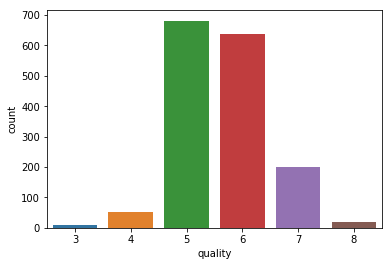

In [67]:
sns.countplot(x='quality', data=wine_data)

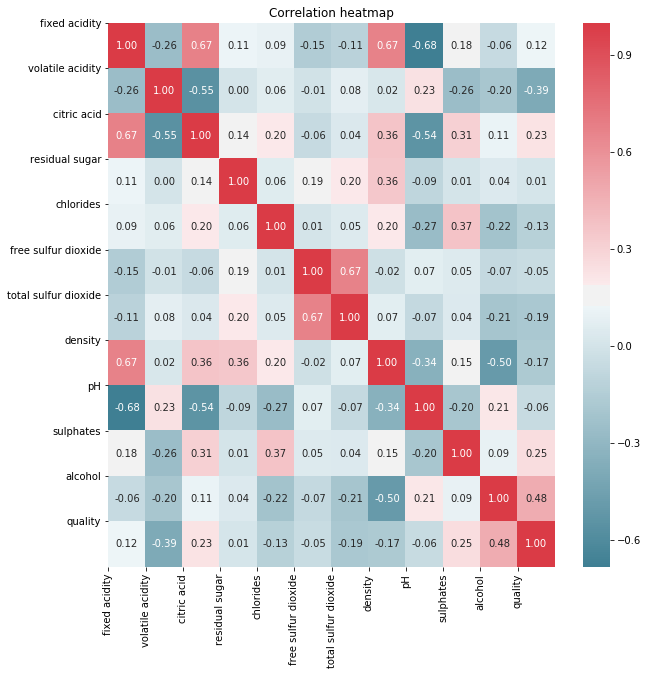

In [68]:
corr_df = wine_data
corr = corr_df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Color Map, red & blue
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Add title
plt.title('Correlation heatmap')
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

## Data Preparation

In [69]:
# Changing the target variable to 0=> Bad, 1=> Good
# So, it is either good quality or bad quality wine
# It will also help in balancing the dataset
wine_data.loc[wine_data.quality <= 5, 'target'] = 0
wine_data.loc[wine_data.quality >= 6, 'target'] = 1

display(wine_data.head())
display(Counter(wine_data['target']))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.0


Counter({0.0: 744, 1.0: 855})

## Train Test split

In [70]:
X = wine_data.drop(['quality','target'],axis=1)
y = wine_data['target']
display(X.head())
display(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: target, dtype: float64

## Scaling the data

In [71]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Neural network 1

In [72]:
mlp1 = MLPClassifier(hidden_layer_sizes=(2, 2),max_iter=500)
mlp1.fit(X_train,y_train)
predictions = mlp1.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[130  48]
 [ 65 157]]
             precision    recall  f1-score   support

        0.0       0.67      0.73      0.70       178
        1.0       0.77      0.71      0.74       222

avg / total       0.72      0.72      0.72       400



In [73]:
print(len(mlp1.coefs_))
print(mlp1.coefs_)

print(len(mlp1.coefs_[0]))

print(len(mlp1.intercepts_[0]))

3
[array([[ 0.08317042, -0.12171715],
       [-0.69081608, -0.41653544],
       [-0.0902027 ,  0.07049579],
       [ 0.28879958,  0.1763687 ],
       [-0.37014993, -1.0780095 ],
       [ 0.44195423,  0.34308847],
       [-0.64722081,  0.18980807],
       [-0.30138618, -0.16304698],
       [ 0.03821272,  0.42664715],
       [ 0.29133031, -1.1318314 ],
       [ 0.88087994, -0.13948522]]), array([[-1.1826291 ,  1.0732907 ],
       [ 0.34059206, -1.32708423]]), array([[-0.90016943],
       [ 0.56483436]])]
11
2


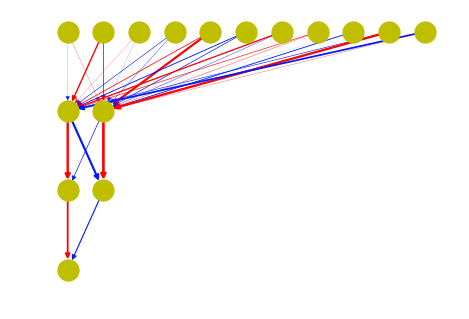

In [74]:
show_ann(mlp1)

## Neural Network 2

In [75]:
mlp2 = MLPClassifier(hidden_layer_sizes=(15, 15, 15),max_iter=10000)
mlp2.fit(X_train,y_train)
predictions = mlp2.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[134  44]
 [ 45 177]]
             precision    recall  f1-score   support

        0.0       0.75      0.75      0.75       178
        1.0       0.80      0.80      0.80       222

avg / total       0.78      0.78      0.78       400



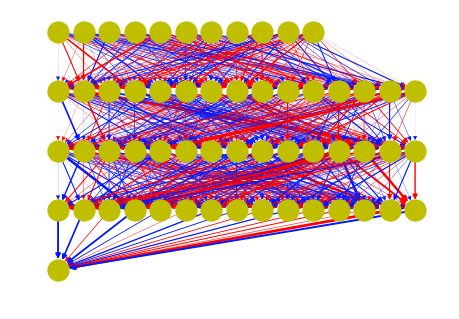

In [76]:
show_ann(mlp2)

## Neural Network 3

In [77]:
mlp3 = MLPClassifier(hidden_layer_sizes=(30, 30, 15),max_iter=10000)
mlp3.fit(X_train,y_train)
predictions = mlp3.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[141  37]
 [ 40 182]]
             precision    recall  f1-score   support

        0.0       0.78      0.79      0.79       178
        1.0       0.83      0.82      0.83       222

avg / total       0.81      0.81      0.81       400



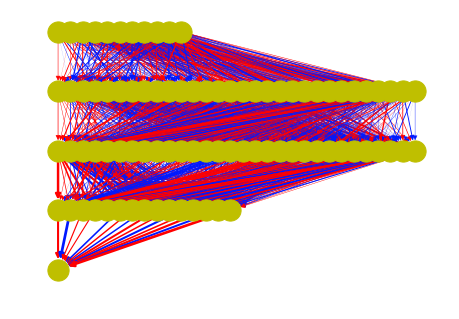

In [80]:
show_ann(mlp3)

In [79]:
mlp4 = MLPClassifier(activation='logistic', solver='adam', learning_rate='adaptive',hidden_layer_sizes=(30, 30, 15),max_iter=10000)
mlp4.fit(X_train,y_train)
predictions = mlp4.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[129  49]
 [ 48 174]]
             precision    recall  f1-score   support

        0.0       0.73      0.72      0.73       178
        1.0       0.78      0.78      0.78       222

avg / total       0.76      0.76      0.76       400

